## **My Model**

In [1]:
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_ipcw , integrated_brier_score , brier_score
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
import torch
import torchtuples as tt
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard

from eval_surv_copy import EvalSurv

# vars
q_cuts = 10
_cuts = 20

In [2]:
# Import Data
flchain = pd.read_csv("resources/other_data/FLCHAIN.csv")
# nwtco = pd.read_csv("resources/other_data/NWTCO.csv")
# whas = pd.read_excel("resources/other_data/whas.xlsx")
# gbsg = pd.read_csv("resources/other_data/gbsg.csv")
# metabric = pd.read_csv("resources/other_data/METABRIC_RNA_Mutation.csv" , low_memory = False)

In [3]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

In [4]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x).to(torch.float32))
        return output   

In [5]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, durations, events):
        self.data = features
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.durations.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur , eve

In [6]:
class Surv_Matrix:
    def __init__(self , duration_index , events , cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [7]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        # self.events = events
        
    def discrete_q_transform(self , q_cuts=10):
        '''
        cut at quantiles
        '''
        self.quantiles = np.linspace(0 , 1 , q_cuts)
        self.bin_edges = np.quantile(self.durations , self.quantiles) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = len(np.unique(self.duration_index))
        # print(self.n_duration_index)
        assert self.n_duration_index == q_cuts , 'must match'
        return self.duration_index
    
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [8]:
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [9]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.2 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

In [10]:
df_train , df_test , df_val = train_test_splitter(flchain)

In [11]:
numeric_preprocessing = Pipeline(steps=[('scaling', StandardScaler()),('imputing' , SimpleImputer())])
categorical_preprocessing_1 = Pipeline(steps=[('encoding', ModifiedLabelEncoder())])
categorical_preprocessing_2 = Pipeline(steps=[('encoding', ModifiedLabelEncoder())])
# null_preprocessing = Pipeline(steps=[('leaving', None),])

numeric_features = ['age','sample.yr','kappa','lambda','flc.grp','creatinine','mgus']
categorical_feature_1 =  ['sex']
categorical_feature_2 = ['chapter']
# null_features = ['x2', 'x3', 'x6']

preprocessing = ColumnTransformer(transformers=[
    ('numeric', numeric_preprocessing, numeric_features),
    ('categorical_1', categorical_preprocessing_1, categorical_feature_1),
    ('categorical_2', categorical_preprocessing_2, categorical_feature_2)
    ]
)

train_pipeline = Pipeline(steps=[('preprocessing', preprocessing)])
test_pipeline = Pipeline(steps=[('preprocessing', preprocessing)])
val_pipeline = Pipeline(steps=[('preprocessing', preprocessing)])

_df_train = train_pipeline.fit_transform(df_train)
_df_test = test_pipeline.fit_transform(df_test)
_df_val = val_pipeline.fit_transform(df_val)

c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-v

In [12]:
# get_features = lambda df: (df.drop(['duration' , 'event'] , axis = 1).values)
get_outcomes = lambda df: (df['futime'].values , df['death'].values)

# features = get_features(df_train)
_outcomes_train = get_outcomes(df_train)
_outcomes_test = get_outcomes(df_test)
_outcomes_val = get_outcomes(df_val)

In [13]:
t = Transforms(durations = _outcomes_train[0])
dur_idx = t.discrete_transform(_cuts = q_cuts)

t_test = Transforms(durations = _outcomes_test[0])
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

t_val = Transforms(durations = _outcomes_val[0])
dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)

In [14]:
_comp = _df_train.shape[1]

pca = PCA(n_components = _comp)
fit_pca = pca.fit(_df_train)
x_train = fit_pca.transform(_df_train)
# reduced_features = fit_pca.transform(x_train)

pca_test = PCA(n_components = _comp)
fit_pca_test = pca_test.fit(_df_test)
x_test = fit_pca_test.transform(_df_test)
# reduced_features_test = fit_pca_test.transform(x_test)

pca_val = PCA(n_components = _comp)
fit_pca_val = pca_test.fit(_df_val)
x_val = fit_pca_val.transform(_df_val)
# reduced_features_val = fit_pca_val.transform(x_val)

In [15]:
input_size = _df_train.shape[1]
hidden_size = 32
output_size = t.n_duration_index


# Create an instance of your custom dataset
dataset = MyDataset(_df_train, dur_idx , _outcomes_train[1]) # need to change outcomes[0] to indexed version

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 500
learning_rate = 0.01
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 10

# build net
net = MLP(input_size , hidden_size , output_size)

# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [16]:
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = _outcomes_val[1] , cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

l = generic_Loss()

best_loss = np.Inf

# Training loop
for epoch in range(num_epochs):
    for batch_id , (patient_image , dur , eve) in enumerate(dataloader):
        # Prime for training
        net.train()
        
        # forward pass
        phi_train = net(patient_image)

        # make survival matrix
        sm = Surv_Matrix(duration_index = dur, events = eve , cuts = q_cuts)
        surv_mat = sm.make_survival_matrix()        

        # get loss
        loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        net.eval()
        with torch.no_grad():
            phi_val = net(_df_val)
            val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break


    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

# turn training off
# net.eval()

Epoch 1: Training Loss: 3.1003, Val Loss: 1.8923
Epoch 51: Training Loss: 0.6921, Val Loss: 0.6860
Epoch 101: Training Loss: 0.5837, Val Loss: 0.6410
Epoch 151: Training Loss: 0.6069, Val Loss: 0.6295
Epoch 201: Training Loss: 0.5869, Val Loss: 0.6064
Epoch 251: Training Loss: 0.6600, Val Loss: 0.6379
Epoch 301: Training Loss: 0.6056, Val Loss: 0.6114
Epoch 351: Training Loss: 0.5536, Val Loss: 0.6159
Epoch 401: Training Loss: 0.6202, Val Loss: 0.6181
Epoch 451: Training Loss: 0.5779, Val Loss: 0.6013


In [17]:
with torch.no_grad():
    hazards = torch.sigmoid(net(_df_test))
    survival = torch.log(1 - hazards).cumsum(1).exp()

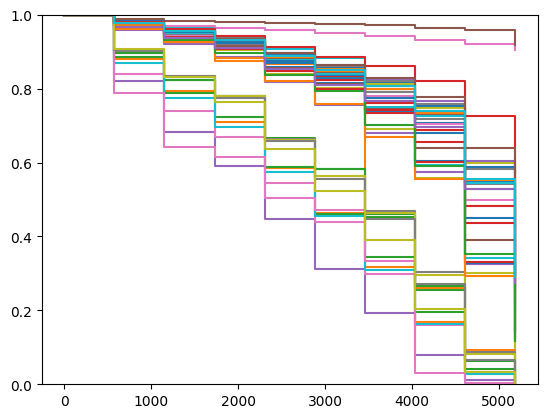

In [18]:
for i , surv in enumerate(survival.detach().numpy()[:40]):
    plt.step(t.bin_edges , surv , where = 'post' , label = i)
    # plt.legend()
    plt.ylim(0 , 1)

In [19]:
survival.detach().numpy().T.shape , _outcomes_test[0].shape , _outcomes_test[1].shape

((10, 1260), (1260,), (1260,))

shapes : (1260, 1260, 1260, 1260)
0.9307697531793768
0.5303473125937219


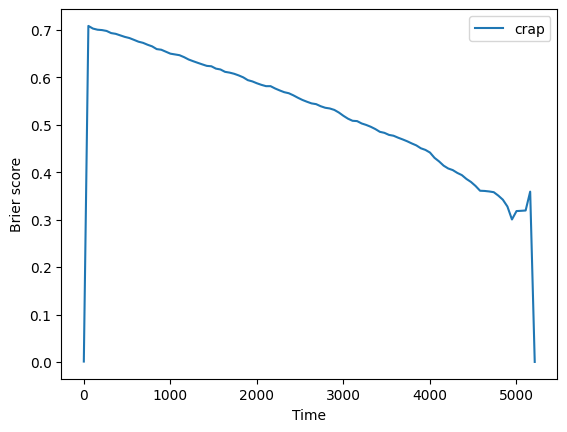

In [20]:
ev_ = EvalSurv(pd.DataFrame(survival.detach().numpy().T) , _outcomes_test[0] , _outcomes_test[1] , censor_surv='km')
print(ev_.concordance_td())

time_grid = np.linspace(_outcomes_test[0].min(), _outcomes_test[0].max(), 100)
print(ev_.integrated_brier_score(time_grid))

ev_.brier_score(time_grid).rename('crap').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

## **havak/pycox**

0:	[0s / 0s],		train_loss: 3.7059,	val_loss: 2.1815
1:	[0s / 0s],		train_loss: 1.5593,	val_loss: 0.8238
2:	[0s / 0s],		train_loss: 0.7508,	val_loss: 0.7087
3:	[0s / 0s],		train_loss: 0.6664,	val_loss: 0.6890
4:	[0s / 0s],		train_loss: 0.6327,	val_loss: 0.6670
5:	[0s / 0s],		train_loss: 0.6210,	val_loss: 0.6688
6:	[0s / 0s],		train_loss: 0.6126,	val_loss: 0.6381
7:	[0s / 0s],		train_loss: 0.6160,	val_loss: 0.6612
8:	[0s / 0s],		train_loss: 0.5997,	val_loss: 0.6273
9:	[0s / 0s],		train_loss: 0.5996,	val_loss: 0.6513
10:	[0s / 0s],		train_loss: 0.5968,	val_loss: 0.7068
11:	[0s / 0s],		train_loss: 0.6101,	val_loss: 0.6479
12:	[0s / 0s],		train_loss: 0.5909,	val_loss: 0.6488
13:	[0s / 0s],		train_loss: 0.5852,	val_loss: 0.6307
14:	[0s / 0s],		train_loss: 0.5764,	val_loss: 0.6162
15:	[0s / 0s],		train_loss: 0.5859,	val_loss: 0.6233
16:	[0s / 0s],		train_loss: 0.5838,	val_loss: 0.6663
17:	[0s / 0s],		train_loss: 0.5895,	val_loss: 0.6613
18:	[0s / 0s],		train_loss: 0.5873,	val_loss: 0.6668
19:

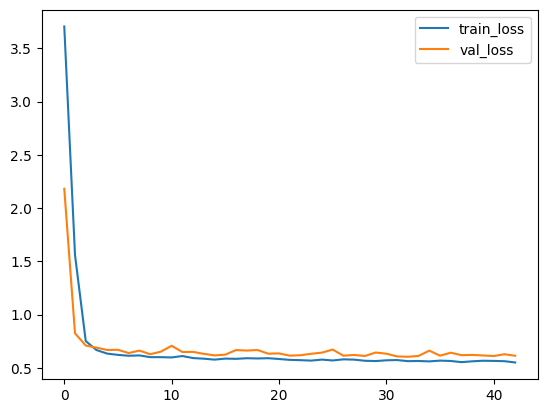

In [21]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['futime'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (_df_train.astype('float32'), y_train)
val = (_df_val.astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

in_features = _df_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, out_features)
)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(_df_train.astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

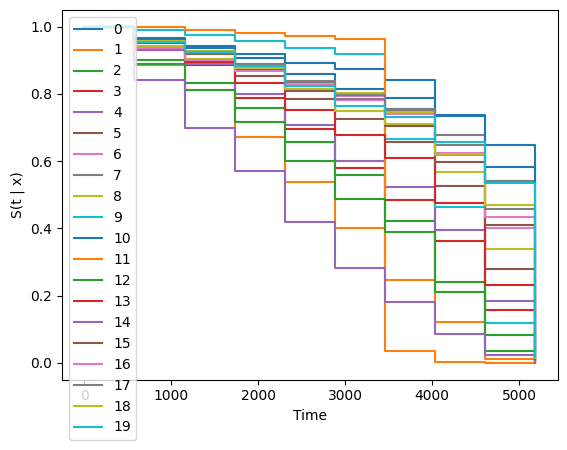

In [22]:
surv = model.predict_surv_df(_df_test.astype('float32'))

surv.iloc[:, :20].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [23]:
surv.shape , durations_test.shape , events_test.shape

((10, 1260), (1260,), (1260,))

shapes : (1260, 1260, 1260, 1260)
td-concordance 0.8300153275035661
integrated brier score 0.10396876524942629


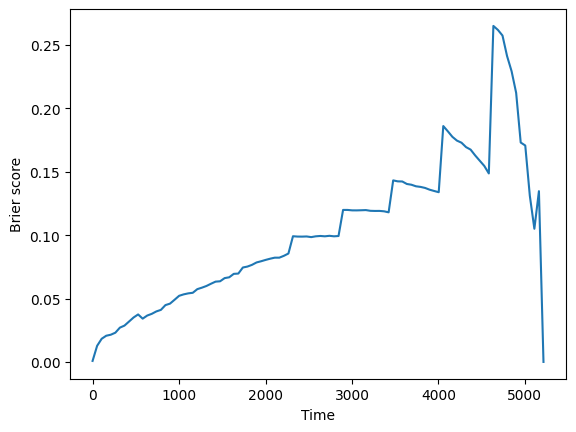

In [24]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')